# Human Pose estimation - Lab CudaVision SS23

# Project Structure

### Datasets
conv_mixer/dataset_ais_xyz.py - dataset class for AIS lab dataset 
h36m/datasets/dataset_h36m.py - dataset class for H3.6m dataset, xyz format
h36m/datasets/dataset_h36m_ang.py - dataset class for H3.6m dataset, axis-angle format

### Encoding
conv_mixer/encoding/positional_encoding.py - encoding of pose vector, with an option to add sinusoidal encoding

### Model
h36m/conv_mixer_model.py - ConvMixer model

### Training
h36m/train_mixer_ais.py - training script for AIS lab dataset
h36m/train_mixer_h36m.py - training script for H3.6m dataset

### Hyperparameter search
optuna_search/conv_optuna_main.py - hyperparameter search for both datasets

### Visualization
conv_mixer/utils/visualization_helpers_ais.py - functions for visualization of AIS dataset
conv_mixer/utils/visualization_helpers_h3m.py - functions for visualization of H3.6m dataset
conv_mixer/utils/visualization - gifs and images used in this notebook


# Visualization of the data
## H3.6m dataset

The dataset contains 17 scenarios:

In [1]:
scenarios = ["walking", "eating", "smoking", "discussion", "directions",
                    "greeting", "phoning", "posing", "purchases", "sitting",
                    "sittingdown", "takingphoto", "waiting", "walkingdog",
                    "walkingtogether"]

The actions are performed by several subjects (human actors), each of them is identified by a number:

In [2]:
subs = [
    [1, 6, 7, 8, 9], # train
    [11], # validation
    [5] # test
]

The original dataset is captured at 50Hz (1 / 20ms). We will apply a downsampling factor of 2 -> 25Hz (1 / 40ms).
10 frames are used as seed frames, and the model is trained to predict the next 10 frames. (400ms seed, 400ms prediction)


## Joint xyz coordinate format

33 joints are tracked for each frame of the sequence. The joints are identified by a number:

In [3]:
joint_name_h3m = [
    "Hips", "RightUpLeg", "RightLeg", "RightFoot", "RightToeBase", "Site", "LeftUpLeg", "LeftLeg", "LeftFoot",
    "LeftToeBase", "Site", "Spine", "Spine1", "Neck", "Head", "Site", "LeftShoulder", "LeftArm", "LeftForeArm",
    "LeftHand", "LeftHandThumb", "Site", "L_Wrist_End", "Site", "RightShoulder", "RightArm", "RightForeArm",
    "RightHand", "RightHandThumb", "Site", "R_Wrist_End", "Site"
]

Several joints are constant or are at same position with other joints, and will be ignored:

In [4]:
import numpy as np

joint_to_ignore = np.array([0, 1, 6, 11, 16, 20, 23, 24, 28, 31])

print('joints to be ignored:', np.array(joint_name_h3m)[joint_to_ignore])
print('number of joints left:', len(joint_name_h3m) - len(joint_to_ignore))

joints to be ignored: ['Hips' 'RightUpLeg' 'LeftUpLeg' 'Spine' 'LeftShoulder' 'LeftHandThumb'
 'Site' 'RightShoulder' 'RightHandThumb' 'Site']
number of joints left: 22


The raw data is provided in the axis-angle format. The xyz coordinates are obtained by an exponential map, then the global rotation and translation are removed (local movement).

For visualization purposes, we will show a long sequence of 200 frames. Our models are trained on 10 frames, and predict the next 10 frames.

In [6]:
import sys
sys.path.append('/home/azhuavlev/PycharmProjects/MotionMixerConv')
from h36m.datasets import dataset_h36m, dataset_h36m_ang
%load_ext autoreload
%autoreload 2

dataset_xyz = dataset_h36m.H36M_Dataset(
    data_dir='/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses',
    input_n=100,
    output_n=100,
    skip_rate=2,
    split=0
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Example preprocessed batch, joint coordinates are im millimeters (mm):
_Important note_: h3.6m uses OpenCV coordinate system, which has different coordinate axes orientation:
Matplotlib: x right, y forward, z up
Opencv: x right, y down, z forward
To convert between them, we need to swap y and z axes, and negate y axis.
This does *not* affect the *training*, but is relevant for visualization.

In [6]:
batch = dataset_xyz[0][:, dataset_xyz.dimensions_to_use]

print(batch)
print('batch.shape', batch.shape)

[[ -71.22052  -419.46445   128.04242  ... -233.02156  -241.97878
    66.888115]
 [ -70.48413  -419.0326    129.09505  ... -236.51244  -242.83264
    67.11383 ]
 [ -69.48038  -418.509     130.29828  ... -239.31981  -242.51956
    69.43913 ]
 ...
 [-118.77522  -373.72687   237.24037  ... -275.61002  -238.96727
    23.281116]
 [-111.79299  -370.53876   241.67976  ... -271.5594   -236.72733
    39.22251 ]
 [ -98.78412  -369.84366   241.25525  ... -268.8989   -233.02702
    52.89633 ]]
batch.shape (200, 66)


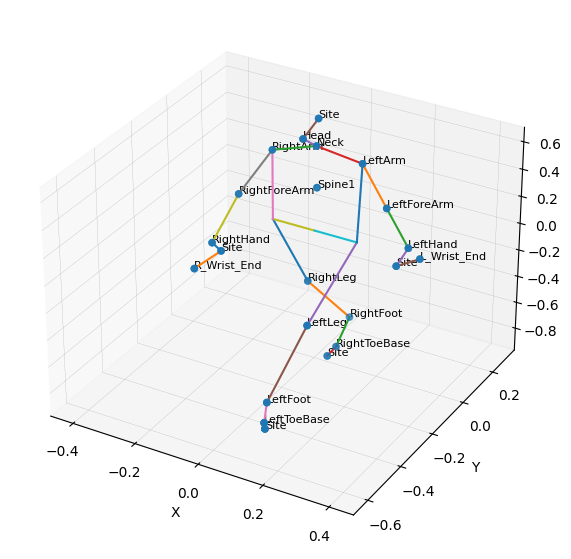

In [19]:
import conv_mixer.utils.visualization_helpers_h3m as visualization_helpers_h3m

visualization_helpers_h3m.visualize_batch_single_h3m(dataset_xyz[90])

![SegmentLocal](visualization/datasets/animation.gif "segment")

## Axis-angle format

The second possible format is axis-angle. Again, the global rotation and translation are removed (local movement), but we use less joints than in the xyz format. Train/validation/test splits and the number of sequences are the same.

In [11]:
dimensions_to_use_angle = np.array(
            [6, 7, 8, 9, 12, 13, 14, 15, 21, 22, 23, 24, 27, 28, 29, 30, 36, 37, 38, 39, 40, 41, 42,
             43, 44, 45, 46, 47, 51, 52, 53, 54, 55, 56, 57, 60, 61, 62, 75, 76, 77, 78, 79, 80, 81, 84, 85, 86])
dimensions_to_ignore_angle = np.array(
            [0, 1, 2, 3, 4, 5, 10, 11, 16, 17, 18, 19, 20, 25, 26, 31, 32, 33, 34, 35, 48, 49, 50, 58,
              59, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 82, 83, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
              98])
print('number of joints to use:', len(dimensions_to_use_angle) // 3)
print('number of joints to ignore:', len(dimensions_to_ignore_angle) //3)

number of joints to use: 16
number of joints to ignore: 17


In [12]:
dataset_angle = dataset_h36m_ang.H36M_Dataset_Angle(
    data_dir='/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses',
    input_n=100,
    output_n=100,
    skip_rate=2,
    split=0
)

In [13]:
batch_angle = dataset_angle[0][:, dimensions_to_use_angle]

print(batch_angle)
print('batch_angle.shape', batch_angle.shape)

[[ 0.3230213 -0.4831149 -0.0673216 ...  0.1473034 -0.1267874 -0.0072563]
 [ 0.3259532 -0.4838686 -0.0682784 ...  0.1349617 -0.0768555  0.0021032]
 [ 0.3294488 -0.4855806 -0.0695968 ...  0.1272881 -0.0470906  0.0103329]
 ...
 [ 0.5543316 -0.6687866  0.1618684 ...  0.1438099  0.2838625 -0.0268883]
 [ 0.5716785 -0.6677975  0.1498878 ...  0.1313288  0.2131509  0.0040503]
 [ 0.5799299 -0.7250111  0.1374053 ...  0.1095381  0.1248537  0.0352608]]
batch_angle.shape (200, 48)


## Dataset captured in AIS lab

The dataset contains 8 actions:

In [ ]:
actions_ais = [
    '2021-08-04-singlePerson_000',
    '2021-08-04-singlePerson_001',
    '2021-08-04-singlePerson_002', # test
    '2021-08-04-singlePerson_003',
    '2022-05-26_2persons_000',
    '2022-05-26_2persons_001', # validation
    '2022-05-26_2persons_002', # test
    '2022-05-26_2persons_003'
]

The dataset captures 27 keypoints, of which only 19 are used. The data is provided in both xyz and axis-angle formats.

In [14]:
joints_ais = [
    "Nose", "Neck", "RShoulder", "RElbow", "RWrist", "LShoulder", "LElbow", "LWrist", "MidHip", "RHip", "RKnee",
    "RAnkle", "LHip", "LKnee", "LAnkle", "REye", "LEye", "REar", "LEar"
]
joints_ais_unused = [
    "Head", "Belly", "LBToe", "LSToe", "LHeel", "RBToe", "RSToe", "RHeel"
]

Input data format is JSON:

In [10]:
import os

# list only json files, without the extension
all_files = os.listdir("/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses")
json_files = [f[:-5] for f in all_files if f.endswith(".json")]
print(sorted(json_files))

['2021-08-04-singlePerson_000', '2021-08-04-singlePerson_001', '2021-08-04-singlePerson_002', '2021-08-04-singlePerson_003', '2022-05-26_2persons_000', '2022-05-26_2persons_001', '2022-05-26_2persons_002', '2022-05-26_2persons_003']


In [15]:
import json

in_file_name = "/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses/2021-08-04-singlePerson_000.json"
with open(in_file_name, 'r') as f:
    pose_data = json.load(f)
pose_data[0]['person']['keypoints'][0]

{'score': 3.3462276458740234,
 'pos': [-1.579332303842465, 5.254447240387596, 1.2453899554859404],
 'cov': [0.00028858751417853756,
  -0.00014108748570844474,
  9.386520816399225e-06,
  0.0012445461087687588,
  -0.0002077309460947308,
  0.00025123770636866134]}

Some joints have score of 0, they need to be ignored

In [16]:
pose_data[0]['person']['keypoints'][-1]

{'score': 0.0, 'pos': [0.0, 0.0, 0.0], 'cov': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

## Raw dataset

Same as before, we show 200 frames for visualization purposes.

In [6]:
import conv_mixer.datasets.dataset_ais_xyz as dataset_ais_xyz
dataset_ais_raw = dataset_ais_xyz.DatasetAISxyz(
    data_dir="/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses",
    input_n=100,
    output_n=100,
    skip_rate=1,
    actions=[
        "2022-05-26_2persons_003",
    ],
    smoothing_alpha=0.99
)

*********************************
Reading action 2022-05-26_2persons_003
Failed to process frame 1213 in action 2022-05-26_2persons_003: Keypoint 0 has score 0
Total n of frames 1744
Failed to process 1 frames
indices of failed frames: 1213, 
Current n of sequences: 1344


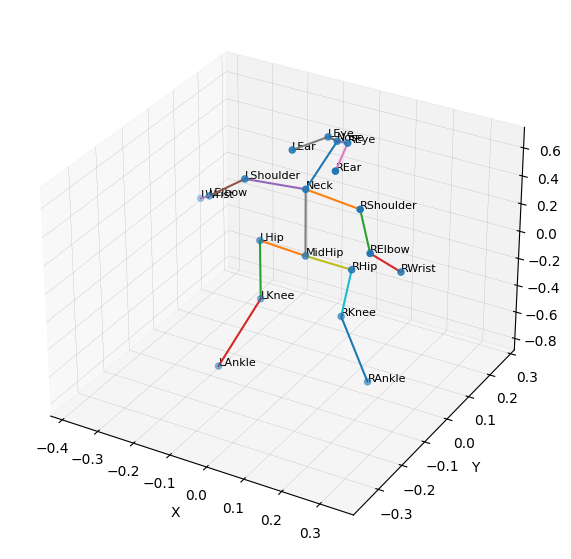

In [16]:
import conv_mixer.utils.visualization_helpers_ais
conv_mixer.utils.visualization_helpers_ais.visualize_batch_single_ais(dataset_ais_raw[101])

In [8]:
# import conv_mixer.visualization_helpers
conv_mixer.utils.visualization_helpers_ais.make_animation_ais(dataset_ais_raw[510], add_title=True, add_joint_names=True,
                                                          save_name='animation_ais_1')

![SegmentLocal](visualization/datasets/animation_ais_1.gif "segment")

## Smoothing with alpha=0.15

In [13]:
import conv_mixer.datasets.dataset_ais_xyz as dataset_ais_xyz
dataset_ais = dataset_ais_xyz.DatasetAISxyz(
    data_dir="/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses",
    input_n=100,
    output_n=100,
    skip_rate=1,
    actions=[
        "2022-05-26_2persons_003",
    ],
    smoothing_alpha=0.15
)

*********************************
Reading action 2022-05-26_2persons_003
Failed to process frame 1213 in action 2022-05-26_2persons_003: Keypoint 0 has score 0
Total n of frames 1744
Failed to process 1 frames
indices of failed frames: 1213, 
Current n of sequences: 1344


In [ ]:
import conv_mixer.utils.visualization_helpers
conv_mixer.utils.visualization_helpers_ais.make_animation_ais(dataset_ais[510], add_title=True, add_joint_names=True,
                                                          save_name='animation_ais_015')

![SegmentLocal](visualization/datasets/animation_ais_015.gif "segment")

# Model architecture

In [8]:
import h36m.conv_mixer_model as conv_mixer_model

model = conv_mixer_model.ConvMixer(
    num_blocks=6,
    dimPosIn=48,
    dimPosEmb=192,
    dimPosOut=48,
    in_nTP=10,
    out_nTP=10,
    conv_nChan=8,
    conv1_kernel_shape=(5, 5),
    conv1_stride=(1,1),
    conv1_padding=(0,1),
    mode_conv='twice',
    activation='gelu',
    regularization=0,
    use_se=True,
    r_se=4,
    use_max_pooling=False,
    encoder_n_harmonic_functions=0
)
model

ConvMixer(
  (encoder): PoseEncoder(
    (embed_mlp): Linear(in_features=48, out_features=192, bias=True)
    (channelUpscaling): Linear(in_features=1, out_features=8, bias=True)
  )
  (Mixer_Block): ModuleList(
    (0-5): 6 x ConvMixerBlock(
      (conv1): ConvBlock(
        (conv): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(0, 1))
        (reg): Identity()
        (act): GELU(approximate='none')
      )
      (se): MultiChanSELayer(
        (squeezeBlock): AdaptiveAvgPool2d(output_size=(1, 1))
        (excitationBlock): Sequential(
          (0): Linear(in_features=10, out_features=2, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=2, out_features=10, bias=False)
          (3): Sigmoid()
        )
      )
      (LN1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (conv2): ConvBlock(
        (conv): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
        (reg): Identity()
        (act): GELU(approximate='none')


In the following, we will present gifs with model outputs for each action, and quantitative results for each action.
More detailed information about experiments can be found in the report.

# Best model, H3.6m dataset, 10 frames prediction

## Qualitative results on each action

In [ ]:
# list all images in visualization/best_model_h36m
import os
import glob

images = sorted(glob.glob("visualization/best_model_h36m/*.gif"))
print(images)

<table>
  <tr>
    <td><img src="visualization/best_model_h36m/directions_1_10.gif" width="320" height="240"><br />directions</td>
    <td><img src="visualization/best_model_h36m/discussion_1_10.gif" width="320" height="240"><br />discussion</td>
    <td><img src="visualization/best_model_h36m/eating_1_10.gif" width="320" height="240"><br />eating</td>
  </tr>
    <tr>
        <td><img src="visualization/best_model_h36m/greeting_1_10.gif" width="320" height="240"><br />greeting</td>
        <td><img src="visualization/best_model_h36m/phoning_1_10.gif" width="320" height="240"><br />phoning</td>
        <td><img src="visualization/best_model_h36m/posing_1_10.gif" width="320" height="240"><br />posing</td>
    </tr>
    <tr>
        <td><img src="visualization/best_model_h36m/purchases_1_10.gif" width="320" height="240"><br />purchases</td>
        <td><img src="visualization/best_model_h36m/sitting_1_10.gif" width="320" height="240"><br />sitting</td>
        <td><img src="visualization/best_model_h36m/sittingdown_1_10.gif" width="320" height="240"><br />sittingdown</td>
    </tr>
    <tr>
        <td><img src="visualization/best_model_h36m/smoking_1_10.gif" width="320" height="240"><br />smoking</td>
        <td><img src="visualization/best_model_h36m/takingphoto_1_10.gif" width="320" height="240"><br />takingphoto</td>
        <td><img src="visualization/best_model_h36m/waiting_1_10.gif" width="320" height="240"><br />waiting</td>
    </tr>
    <tr>
        <td><img src="visualization/best_model_h36m/walking_1_10.gif" width="320" height="240"><br />walking</td>
        <td><img src="visualization/best_model_h36m/walkingdog_1_10.gif" width="320" height="240"><br />walkingdog</td>
        <td><img src="visualization/best_model_h36m/walkingtogether_1_10.gif" width="320" height="240"><br />walkingtogether</td>
    </tr>
</table>


## Quantitative results on each action

|                 | mpjpe |  auc_pck | joint_angle | euler_angle |
|:----------------|------:|---------:|------------:|------------:|
| walking         | 31.93 |     0.87 |        0.43 |        0.43 |
| eating          | 22.84 |     0.91 |        0.40 |        0.40 |
| smoking         | 23.33 |     0.91 |        0.50 |        0.54 |
| discussion      | 37.35 |     0.86 |        0.51 |        0.66 |
| directions      | 30.23 |     0.89 |        0.48 |        0.49 |
| greeting        | 46.38 |     0.83 |        0.71 |        0.75 |
| phoning         | 29.13 |     0.89 |        0.75 |        1.04 |
| posing          | 42.31 |     0.84 |        0.67 |        0.79 |
| purchases       | 44.53 |     0.84 |        0.72 |        0.78 |
| sitting         | 31.92 |     0.87 |        0.59 |        0.60 |
| sittingdown     | 44.49 |     0.83 |        0.72 |        0.75 |
| takingphoto     | 31.92 |     0.87 |        0.43 |        0.44 |
| waiting         | 31.74 |     0.88 |        0.62 |        0.63 |
| walkingdog      | 56.19 |     0.79 |        0.81 |        0.85 |
| walkingtogether | 29.13 |     0.88 |        0.41 |        0.41 |
| Average         | 35.62 |     0.92 |        0.56 |        0.61 |

# Best model, AIS dataset, 10 frames prediction, local movement

In [ ]:
images = sorted(glob.glob("visualization/best_model_ais_local/*.gif"))
print(images)

<table>
  <tr>
    <td><img src="visualization/best_model_ais_local/2021-08-04-singlePerson_000_20_10.gif" width="320" height="240"><br />singlePerson_000</td>
    <td><img src="visualization/best_model_ais_local/2021-08-04-singlePerson_001_20_10.gif" width="320" height="240"><br />singlePerson_001</td>
    <td><img src="visualization/best_model_ais_local/2021-08-04-singlePerson_002_20_10.gif" width="320" height="240"><br />singlePerson_002</td>
    <td><img src="visualization/best_model_ais_local/2021-08-04-singlePerson_003_20_10.gif" width="320" height="240"><br />singlePerson_003</td>
    </tr>
    <tr>
        <td><img src="visualization/best_model_ais_local/2022-05-26_2persons_000_30_10.gif" width="320" height="240"><br />2persons_000</td>
        <td><img src="visualization/best_model_ais_local/2022-05-26_2persons_001_30_10.gif" width="320" height="240"><br />2persons_001</td>
        <td><img src="visualization/best_model_ais_local/2022-05-26_2persons_002_30_10.gif" width="320" height="240"><br />2persons_002</td>
        <td><img src="visualization/best_model_ais_local/2022-05-26_2persons_003_30_10.gif" width="320" height="240"><br />2persons_003</td>
    </tr>
</table>

## Quantitative results on each action

|                         | split |   mpjpe |   auc_pck |
|:------------------------|:------|--------:|----------:|
| singlePerson_000        | train | 19.3 |  0.93 |
| singlePerson_001        | train | 19.2 |  0.93 |
| singlePerson_002        | test  | 24.2 |  0.91 |
| singlePerson_003        | train | 19.2 |  0.93 |
| 2persons_000            | train | 21.4 |  0.92  |
| 2persons_001            | val   | 29.0 |  0.90 |
| 2persons_002            | test  | 26.3 |  0.91 |
| 2persons_003 | train | 16.0 |  0.94 |

# Best model, AIS dataset, 10 frames prediction, global movement

<table>
  <tr>
    <td><img src="visualization/best_model_ais_global/2021-08-04-singlePerson_000_10_10.gif" width="320" height="240"><br />singlePerson_000</td>
    <td><img src="visualization/best_model_ais_global/2021-08-04-singlePerson_001_10_10.gif" width="320" height="240"><br />singlePerson_001</td>
    <td><img src="visualization/best_model_ais_global/2021-08-04-singlePerson_002_10_10.gif" width="320" height="240"><br />singlePerson_002</td>
    <td><img src="visualization/best_model_ais_global/2021-08-04-singlePerson_003_10_10.gif" width="320" height="240"><br />singlePerson_003</td>
    </tr>
    <tr>
        <td><img src="visualization/best_model_ais_global/2022-05-26_2persons_000_10_10.gif" width="320" height="240"><br />2persons_000</td>
        <td><img src="visualization/best_model_ais_global/2022-05-26_2persons_001_10_10.gif" width="320" height="240"><br />2persons_001</td>
        <td><img src="visualization/best_model_ais_global/2022-05-26_2persons_002_10_10.gif" width="320" height="240"><br />2persons_002</td>
        <td><img src="visualization/best_model_ais_global/2022-05-26_2persons_003_10_10.gif" width="320" height="240"><br />2persons_003</td>
    </tr>
</table>

## Quantitative results on each action

|                             | type   | mpjpe |   auc_pck |
|:----------------------------|:-------|------:|----------:|
| 2021-08-04-singlePerson_000 | train  |  43.7 |  0.85 |
| 2021-08-04-singlePerson_001 | train  |  43.3 |  0.85 |
| 2021-08-04-singlePerson_002 | test   |  65.8 |  0.78 |
| 2021-08-04-singlePerson_003 | train  |  50.8 |  0.82 |
| 2022-05-26_2persons_000     | train  |  53.2 |  0.82 |
| 2022-05-26_2persons_001     | val    | 106.3 |  0.69 |
| 2022-05-26_2persons_002     | test   |  91.9 |  0.70 |
| 2022-05-26_2persons_003     | train  |  47.9 |  0.83 |

## H3.6m dataset, 25 frames autoregressive prediction

<table>
  <tr>
    <td><img src="visualization/best_model_h36m_autoregressive/directions_1_10.gif" width="320" height="240"><br />directions</td>
    <td><img src="visualization/best_model_h36m_autoregressive/discussion_1_10.gif" width="320" height="240"><br />discussion</td>
    <td><img src="visualization/best_model_h36m_autoregressive/eating_1_10.gif" width="320" height="240"><br />eating</td>
  </tr>
    <tr>
        <td><img src="visualization/best_model_h36m_autoregressive/greeting_1_10.gif" width="320" height="240"><br />greeting</td>
        <td><img src="visualization/best_model_h36m_autoregressive/phoning_1_10.gif" width="320" height="240"><br />phoning</td>
        <td><img src="visualization/best_model_h36m_autoregressive/posing_1_10.gif" width="320" height="240"><br />posing</td>
    </tr>
    <tr>
        <td><img src="visualization/best_model_h36m_autoregressive/purchases_1_10.gif" width="320" height="240"><br />purchases</td>
        <td><img src="visualization/best_model_h36m_autoregressive/sitting_1_10.gif" width="320" height="240"><br />sitting</td>
        <td><img src="visualization/best_model_h36m_autoregressive/sittingdown_1_10.gif" width="320" height="240"><br />sittingdown</td>
    </tr>
    <tr>
        <td><img src="visualization/best_model_h36m_autoregressive/smoking_1_10.gif" width="320" height="240"><br />smoking</td>
        <td><img src="visualization/best_model_h36m_autoregressive/takingphoto_1_10.gif" width="320" height="240"><br />takingphoto</td>
        <td><img src="visualization/best_model_h36m_autoregressive/waiting_1_10.gif" width="320" height="240"><br />waiting</td>
    </tr>
    <tr>
        <td><img src="visualization/best_model_h36m_autoregressive/walking_1_10.gif" width="320" height="240"><br />walking</td>
        <td><img src="visualization/best_model_h36m_autoregressive/walkingdog_1_10.gif" width="320" height="240"><br />walkingdog</td>
        <td><img src="visualization/best_model_h36m_autoregressive/walkingtogether_1_10.gif" width="320" height="240"><br />walkingtogether</td>
    </tr>
</table>


|                 |  mpjpe |  auc_pck | joint_angle | euler_angle |
|:----------------|-------:|---------:|------------:|------------:|
| walking         |  75.74 |     0.75 |        0.73 |        2.68 |
| eating          |  58.23 |     0.81 |        0.79 |        2.79 |
| smoking         |  59.10 |     0.80 |        0.86 |        1.98 |
| discussion      |  87.29 |     0.73 |        1.11 |        2.45 |
| directions      |  73.04 |     0.78 |        0.93 |        3.13 |
| greeting        | 104.32 |     0.69 |        1.18 |        3.93 |
| phoning         |  73.25 |     0.76 |        1.20 |        3.33 |
| posing          | 114.53 |     0.66 |        1.43 |        2.69 |
| purchases       |  98.25 |     0.69 |        1.17 |        2.38 |
| sitting         |  80.15 |     0.74 |        1.12 |        3.45 |
| sittingdown     | 102.99 |     0.68 |        1.14 |        2.78 |
| takingphoto     |  81.17 |     0.74 |        0.77 |        2.18 |
| waiting         |  81.32 |     0.74 |        1.41 |        3.42 |
| walkingdog      | 117.01 |     0.64 |        1.38 |        2.70 |
| walkingtogether |  71.04 |     0.76 |        0.70 |        2.18 |
| Average         |  85.21 |     0.71 |        1.12 |        2.84 |

## AIS dataset, 25 frames autoregressive prediction

<table>
  <tr>
    <td><img src="visualization/best_model_ais_autoregressive/2021-08-04-singlePerson_000_20_10.gif" width="320" height="240"><br />singlePerson_000</td>
    <td><img src="visualization/best_model_ais_autoregressive/2021-08-04-singlePerson_001_20_10.gif" width="320" height="240"><br />singlePerson_001</td>
    <td><img src="visualization/best_model_ais_autoregressive/2021-08-04-singlePerson_002_20_10.gif" width="320" height="240"><br />singlePerson_002</td>
    <td><img src="visualization/best_model_ais_autoregressive/2021-08-04-singlePerson_003_20_10.gif" width="320" height="240"><br />singlePerson_003</td>
    </tr>
    <tr>
        <td><img src="visualization/best_model_ais_autoregressive/2022-05-26_2persons_000_30_10.gif" width="320" height="240"><br />2persons_000</td>
        <td><img src="visualization/best_model_ais_autoregressive/2022-05-26_2persons_001_30_10.gif" width="320" height="240"><br />2persons_001</td>
        <td><img src="visualization/best_model_ais_autoregressive/2022-05-26_2persons_002_30_10.gif" width="320" height="240"><br />2persons_002</td>
        <td><img src="visualization/best_model_ais_autoregressive/2022-05-26_2persons_003_30_10.gif" width="320" height="240"><br />2persons_003</td>
    </tr>
</table>

|                             | type   |   mpjpe |  auc_pck |
|:----------------------------|:-------|--------:|---------:|
| 2021-08-04-singlePerson_000 | train  |   35.24 |     0.88 |
| 2021-08-04-singlePerson_001 | train  |   35.85 |     0.88 |
| 2021-08-04-singlePerson_002 | test   |   51.29 |     0.83 |
| 2021-08-04-singlePerson_003 | train  |   42.04 |     0.86 |
| 2022-05-26_2persons_000     | train  |   39.12 |     0.86 |
| 2022-05-26_2persons_001     | val    |   51.20 |     0.83 |
| 2022-05-26_2persons_002     | test   |   44.93 |     0.85 |
| 2022-05-26_2persons_003     | train  |   30.27 |     0.89 |

## References

- https://github.com/MotionMLP/MotionMixer
- https://optuna.org/
- https://pytorch.org/

In [2]:
# convert to html
!jupyter nbconvert --to html --output-dir='.' --output='visualization.html' visualization.ipynb

[NbConvertApp] Converting notebook visualization.ipynb to html
[NbConvertApp] Writing 923152 bytes to visualization.html
